In [7]:
# Libraries Imports
#hide
import argparse
import json
from math import ceil
#import PIL
from PIL import Image
import torch
import numpy as np
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [2]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

In [3]:
# Means and standard deviations for normalize images
mean = [0.485, 0.456, 0.406]
std_dev = [0.229, 0.224, 0.225]


In [4]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    transf = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std_dev)
                                ])
   #img = Image.open(image)
    img_transf = transf(image)
    # TODO: Process a PIL image for use in a PyTorch model
    return img_transf


Getting Probability Prediction

In [5]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = process_image(img).unsqueeze(0)
  
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()
  

## Carregando o modelo treinado

In [6]:
# Setting device available (gpu or cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading Model
model = torch.load('checkpoint.pth', map_location = device)
model.eval()
#model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Realizando inferencias 

Quando utilizamos o modelo treinado para realizar predicoes, estamos realizando *inference*. Geralmente, estamos interessados em realizar a predicao em uma unica imagem. Utilizamos `predict_proba` para esta tarefa.

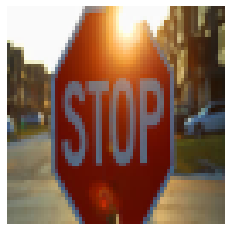

In [13]:
image= 'data/traffic_signs/stop/00000238.jpg'
show_image(image)

In [14]:
pred = predict_proba(model, image)
pred

array([1.3630817e-05, 3.6161115e-08, 4.4442662e-03, 9.9554211e-01],
      dtype=float32)

Relembrando a ordem dos nomes das classes, verificamos que neste caso, o classificador acerta. Em seguida, iremos analisar o desempneho do classificador no dataset completo.

In [15]:
class_names = ['give_way', 'no_entry', 'priority_road',  'stop']

## Carregando o dataset de teste criado

In [16]:
test_folders= sorted(glob("data/traffic_signs/*/"))
test_folders

['data/traffic_signs/give_way/',
 'data/traffic_signs/no_entry/',
 'data/traffic_signs/priority_road/',
 'data/traffic_signs/stop/']

In [17]:
test_files= sorted(glob("data/traffic_signs/*/*jpg"))
len(test_files)

380

In [19]:
class_names = ['give_way', 'no_entry', 'priority_road',  'stop']
len_class = [71, 123, 64, 122]
labels= np.concatenate((np.zeros(71), np.ones(123), 2*(np.ones(64)), 3*(np.ones(122)) ), axis=0)
len(labels)

380

## Predicoes no dataset completo

In [20]:
def predict_data(test_x, model):
    """
    Input: 
        test_x: a list of images filenames
        model: a trained model in eval stage
    Output: 
        predicts: a list of predicts
    """

    # the list for storing predictions
    y_preds = []
    
    for file in test_x:
        pred= np.argmax(predict_proba(model,file))
        y_preds.append(pred)
        
    return y_preds

In [21]:
preds= predict_data(test_files,model)

## Metricas

In [24]:
def metrics(preds, labels):
    """
    Input: 
        test_x: a list of predicts
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
    Output: 
        accuracy: (# of images classified correctly) / (total # of images)
    """
    
    # With the above implementation, preds is a list, but labels is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    
    accuracy = (preds==np.squeeze(labels)).sum()/len(preds)
    
    return accuracy

In [25]:
accuracy = metrics(preds, labels)

In [26]:
accuracy

0.7394736842105263

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [28]:
def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [29]:
accuracy, precision, recall, f1 = get_metrics(labels, preds)
print("Training accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

Training accuracy = 0.739, precision = 0.803, recall = 0.739, f1 = 0.745


In [30]:
#from https://www.curiousily.com/posts/transfer-learning-for-image-classification-using-torchvision-pytorch-and-python/
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

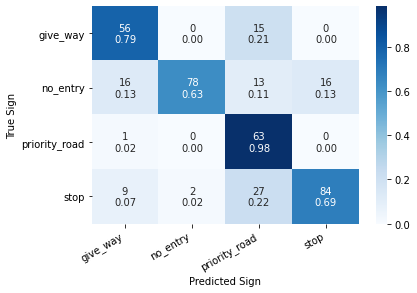

In [32]:
cm = confusion_matrix(labels, preds)
show_confusion_matrix(cm, class_names)

+ Read your test dataset, 
+ get the prediction of your test dataset images 
+ based on real and predicted values, generate the metrics that you consider useful and to evaluate the model, explaining why you considered that.
+ Explain the results of the test.  
